In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
pip install pykalman

In [12]:
# -*- coding: utf-8 -*-


import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pykalman import KalmanFilter
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Flatten, RepeatVector, Permute, multiply, Lambda, Activation, Conv1D, MaxPooling1D, Bidirectional, concatenate
from keras.models import Model
# from keras import backend as K
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [13]:
# Function to apply Kalman filter
def apply_kalman_filter(data):
    kf = KalmanFilter(initial_state_mean=data[0], n_dim_obs=1)
    (filtered_state_means, _) = kf.filter(data)
    return filtered_state_means

In [14]:
def create_attention_model_LSTM(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # LSTM layer
    lstm_out = LSTM(units, return_sequences=True)(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)  # Adjusted input shape to match the output shape of LSTM
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([lstm_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1),output_shape=(units,))(sent_representation)


    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model


# Function to create BiLSTM model with attention mechanism
def create_attention_model_BiLSTM(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # BiLSTM layer
    lstm_out = Bidirectional(LSTM(units, return_sequences=True))(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(lstm_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(2 * units)(attention)  # Adjusted input shape to match the output shape of BiLSTM
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([lstm_out, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=1),output_shape=(units,))(sent_representation)

    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model




def create_attention_model_GRU(input_shape, units):
    inputs = Input(shape=input_shape)

    # Adding 1D CNN layer
    cnn_out = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn_out = MaxPooling1D(pool_size=2)(cnn_out)
    cnn_out = Dropout(0.2)(cnn_out)

    # GRU layer
    gru_out = GRU(units, return_sequences=True)(cnn_out)

    # Attention mechanism
    attention = Dense(1, activation='relu')(gru_out)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)  # Adjusted input shape to match the output shape of GRU
    attention = Permute([2, 1])(attention)
    sent_representation = multiply([gru_out, attention])
    # sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)
    sent_representation = Lambda(lambda xin:  K.sum(xin, axis=1), output_shape=(units,))(sent_representation)

    # Output layer
    output = Dense(1)(sent_representation)

    model = Model(inputs=inputs, outputs=output)
    return model


In [15]:
# Define folder path containing the dataset files
# folder_path = '/content/drive/MyDrive/dataset_cloud/Materna_modified_ds/Materena_traces/GWA-T-13_Materna-Workload-Traces/Materna-Trace-3'
# folder_path = '/content/drive/MyDrive/dataset_cloud/Materna_modified_ds/Materena_traces/GWA-T-13_Materna-Workload-Traces/Materna-Trace-2'
# folder_path = '/content/drive/MyDrive/dataset_cloud/Materna_modified_ds/Materena_traces/GWA-T-13_Materna-Workload-Traces/Materna-Trace-1'


#For Demo a subset of dataset.
folder_path= '/content/drive/MyDrive/dataset/GWA-T-13_Materna-Workload-Traces/small_demo_dataset_materna'

# Get the list of files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [16]:

# Initialize lists to store MAE and MSE for each file
mae_list = []
mse_list = []

# Initialize the model
window_size = 12  # Define window size
train_ratio = 0.4  # Define train ratio
validation_ratio = 0.2  # Define validation ratio
units = 50  # Define number of units for LSTM


# attention_model = create_attention_model_LSTM(input_shape=(window_size, 2), units=units)
# attention_model = create_attention_model_BiLSTM(input_shape=(window_size, 2), units=units)
attention_model = create_attention_model_GRU(input_shape=(window_size, 2), units=units)


attention_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# Iterate over each file
for file_name in file_list:
    # Read data from the file
    print("File:::::>>>>", file_name)
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=',')

    # Check if 'CPU usage [%]' and 'cpu_core' columns exist
    if 'CPU usage [%]' not in df.columns or 'CPU cores' not in df.columns:
        print("Skipping file", file_name, "as it doesn't contain required columns")
        continue

    # Replace commas with periods in the 'CPU usage [%]' column
    df['CPU usage [%]'] = df['CPU usage [%]'].str.replace(',', '.')

    # Convert the 'CPU usage [%]' column to numerical values
    df['CPU usage [%]'] = pd.to_numeric(df['CPU usage [%]'])

    # Extract CPU usage column
    cpu_usage = df['CPU usage [%]'].values.reshape(-1, 1)

    # Apply Kalman filter to CPU usage
    cpu_filtered = apply_kalman_filter(cpu_usage)

    # Scale CPU usage data
    scaler_cpu = MinMaxScaler(feature_range=(0, 1))
    cpu_scaled = scaler_cpu.fit_transform(cpu_filtered)

    # Extract cpu_core column
    cpu_core = df['CPU cores'].values.reshape(-1, 1)

    # Scale cpu_core data
    scaler_core = MinMaxScaler(feature_range=(0, 1))
    core_scaled = scaler_core.fit_transform(cpu_core)

    # Combine scaled CPU usage and cpu_core data
    X = np.concatenate((cpu_scaled, core_scaled), axis=1)

    # Create dataset
    dataX, dataY = [], []
    for i in range(len(X) - window_size - 1):
        a = X[i:(i+window_size)]
        dataX.append(a)
        dataY.append(X[i + window_size])
    X = np.array(dataX)
    y = np.array(dataY)

    # Split data into train and validation sets
    train_size = int(len(X) * train_ratio)
    validation_size = int(len(X) * validation_ratio)
    test_size = len(X) - train_size - validation_size
    X_train, y_train = X[:train_size], y[:train_size]
    X_validation, y_validation = X[train_size:train_size+validation_size], y[train_size:train_size+validation_size]
    X_test, y_test = X[train_size+validation_size:], y[train_size+validation_size:]  # Separate test data

    # Train the model
    history = attention_model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                                  epochs=100, batch_size=16, verbose=1)


    score = attention_model.evaluate(X_test, y_test, verbose=0)
    mae_list.append(score[2])  # Append MAE to the list
    mse_list.append(score[1])  # Append MSE to the list

File:::::>>>> 03.csv
Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0033 - mae: 0.0388 - mse: 0.0033 - val_loss: 0.0033 - val_mae: 0.0394 - val_mse: 0.0033
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0035 - mae: 0.0387 - mse: 0.0035 - val_loss: 0.0032 - val_mae: 0.0397 - val_mse: 0.0032
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0035 - mae: 0.0387 - mse: 0.0035 - val_loss: 0.0032 - val_mae: 0.0411 - val_mse: 0.0032
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0030 - mae: 0.0379 - mse: 0.0030 - val_loss: 0.0031 - val_mae: 0.0392 - val_mse: 0.0031
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0030 - mae: 0.0374 - mse: 0.0030 - val_loss: 0.0031 - val_mae: 0.0393 - val_mse: 0.0031
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032 - mae: 0.0380 - mse: 0.0032 - val_loss: 0.0031 - val_mae: 0.0400 - val_mse: 0.0031
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 

In [17]:
# Calculate final MAE and MSE on test data
final_mae = np.mean(mae_list)
final_mse = np.mean(mse_list)
print("Test MAE:", final_mae)
print("Test MSE:", final_mse)

Test MAE: 0.05471994844265282
Test MSE: 0.017627527164586355


In [18]:
# Define folder path to save the model
model_save_folder = '/content/drive/MyDrive/trained_models/'
# Define file path to save the model
model_save_path = os.path.join(model_save_folder, 'materna_GRU_CPU_w12_60mins.h5')
# Save the model
attention_model.save(model_save_path)
print("Model saved at:", model_save_path)

Model saved at: /content/drive/MyDrive/trained_models/materna_GRU_CPU_w12_60mins.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


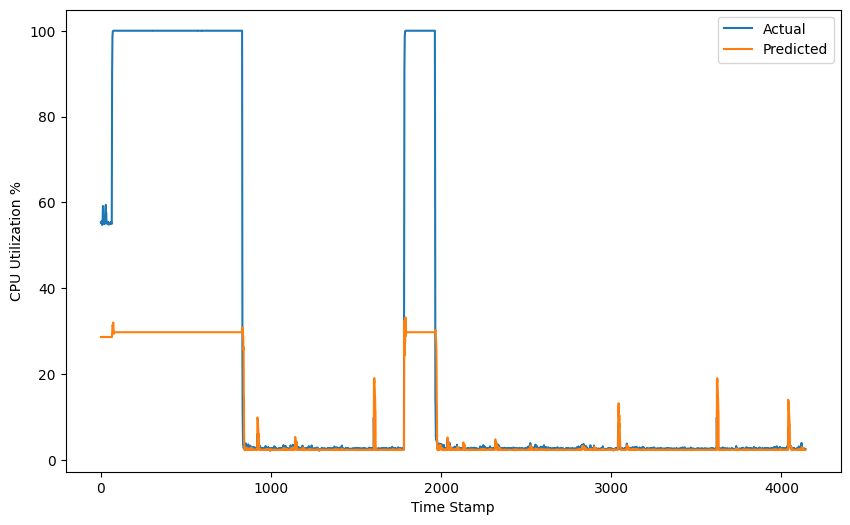

In [20]:
#Predict X_test to print the Graph...
y_pred = attention_model.predict(X_test)
# Inverse transform the scaled predictions and actual values to get the original values
y_pred_inv = scaler_cpu.inverse_transform(y_pred)
y_test_inv = scaler_cpu.inverse_transform(y_test)
y_test_inv=y_test_inv[:, 0]
y_test_inv=y_test_inv
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
# plt.title('Predicted vs Actual CPU Usage [%] (Test Data)')
plt.xlabel('Time Stamp')
plt.ylabel('CPU Utilization %')
plt.legend()
plt.show()
